In [2]:
# import required modules
%cd /home/gridsan/lchan/git-remotes/polychrom_analysis
import os
import sys
from pathlib import Path
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import polychrom
from polychrom.hdf5_format import list_URIs, load_URI, load_hdf5_file

from post_processing.visualization import *
from post_processing.analysis import *
from post_processing.compscores import *
from post_processing.msd import *

import random
import csv
import math
from scipy.stats import rv_continuous

import nglutils as ngu
import nglview as nv

/home/gridsan/lchan/git-remotes/polychrom_analysis


In [2]:
# for visualization of polymer
%load_ext autoreload
%autoreload 2

In [3]:
# load chromosomal data
ABids = np.loadtxt("data/ABidentities_chr21_Su2020_2perlocus.csv", dtype=str) # make sure to change this!
ids = (ABids == "A").astype(int)
chromo = 'normal_logclustered'

# parameter sweep values
param_set = []
act_ratio = [1, 2, 3, 4, 5]
e0 = [0, 0.075, 0.15, 0.225, 0.3]
for a in act_ratio:
    for e in e0:
        param_set.append((a, e))

simnames = [f'stickyBB_{BBenergy}_act{act_ratio}' for (act_ratio, BBenergy) in param_set]

In [9]:
# overwrite method for parameter defaults
def extract_cs(path, every_other=1): # starts and ends are fake here. modify in real code
    """Extract independent snapshots from a single simulation.

    Parameters
    ----------
    path : str
        path to simulation directory
    start : int
        block number to start extracting files from
    every_other : int
        skip this number of blocks in between snapshots (should be large enough
        so that snapshots are decorrelated)
    end : int
        last block to include in trajectory.
    """
    try:
        confs = list_URIs(path)
        if end:
            uris = confs[start:end:every_other]
        else:
            uris = confs[start::every_other]
    except:
        raise Exception("Exception! Something went wrong")
        uris = []
    return uris
def extract_conformations_cs(basepath, ncores=24, chain=True, **kwargs):
    """Extract conformations from multiple simulation replicates to be included in
    ensemble-averaged observables.

    Parameters
    ----------
    basepath : str or Path
        parent directory where each subdirectory is a simulation replicate for one set of parameters
    ncores : int
        number of cores available for parallelization
    chain : bool
        whether to aggregate conformations from multiple simulations into one list.
        Defaults to True.

    Returns
    -------
    conformations : list
        If chain is True, list of hdf5 filenames containing polymer conformations.
        If chain is False, list of lists, where each sublist is from a separate simulation run.
    """
    basepath = Path(basepath)
    rundirs = [f for f in basepath.iterdir() if f.is_dir()]
    runs = len(rundirs)
    extract_func = partial(extract_cs, **kwargs)
    with mp.Pool(ncores) as p:
        confs = p.map(extract_func, rundirs)
    if chain:
        conformations = list(itertools.chain.from_iterable(confs))
        #print(f"Number of simulations in directory: {runs}")
        #print(f"Number of conformations extracted: {len(conformations)}")
        return conformations, runs
    else:
        return confs, runs

In [19]:
# generate and save contact maps. change names as needed
ABids = np.loadtxt("data/ABidentities_chr21_Su2020_blocky2.csv", dtype=str) # make sure to change this!
ids = (ABids == "A").astype(int)
chromo = 'blocky2_logclustered'

# parameter sweep values
param_set = []
act_ratio = [1, 2, 3, 4, 5]
e0 = [0, 0.075, 0.15, 0.225, 0.3]
for a in act_ratio:
    for e in e0:
        param_set.append((a, e))

param_set.extend([(1, 0.175), (2, 0.12), (4, 0.04)]) # normal log clustered
param_set.extend([(1, 0.25), (2, 0.17), (3, 0.1), (4, 0.04)]) # artificial1
param_set.extend([(1, 0.25), (2, 0.16), (3, 0.1), (4, 0.05)]) # artificial2
param_set.extend([(1, 0.25), (2, 0.17), (3, 0.11), (4, 0.06)]) # blocky1
param_set.extend([(1, 0.23), (2, 0.15), (3, 0.10), (4, 0.05)]) # blocky1

simnames = [f'stickyBB_{BBenergy}_act{act_ratio}' for (act_ratio, BBenergy) in param_set]
simpath = simnames
for simname in simpath:
    path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/artificial_chr/{chromo}/{simname}'
    # for all pairs of start_i and end_i (0, 10), (11, 21), (22, 32)...(1089, 1099)
    start_i_list = list(range(0, 1090, 11))
    end_i_list = list(range(10, 1100, 11))
    print(simname)
    for j in range(len(start_i_list)): # same as start_j length
        start = start_i_list[j]
        end = end_i_list[j]
        blocks = f'{start}-{end}'
        set_cutoff = 2.0
        if (Path(path).is_dir() and not Path(f"data/contact_maps/{chromo}/contact_map_{simname}_cutoff{set_cutoff}_blocks{blocks}.npy").is_file()):
            conformations, runs = extract_conformations(path) # could save conformations if large
            mat = contactmaps.monomerResolutionContactMapSubchains(
                filenames=conformations,
                mapStarts=list(range(0, 260300, 1302)),
                mapN=1302,
                cutoff=set_cutoff
            )
            mat[mat==0] = mat[mat > 0].min() / 2
            mat2 = mat / len(conformations) / 200 # divide by 200 again for subchains
                        # save cutoff radius = 2.0 contact map
            np.save(f"data/contact_maps/{chromo}/contact_map_{simname}_cutoff{set_cutoff}_blocks{blocks}.npy", mat2)

stickyBB_0_act1
stickyBB_0.075_act1
stickyBB_0.15_act1
stickyBB_0.225_act1
stickyBB_0.3_act1
stickyBB_0_act2
stickyBB_0.075_act2
stickyBB_0.15_act2
stickyBB_0.225_act2
stickyBB_0.3_act2
stickyBB_0_act3
stickyBB_0.075_act3
stickyBB_0.15_act3
stickyBB_0.225_act3
stickyBB_0.3_act3
stickyBB_0_act4
stickyBB_0.075_act4
stickyBB_0.15_act4
stickyBB_0.225_act4
stickyBB_0.3_act4
stickyBB_0_act5
stickyBB_0.075_act5
stickyBB_0.15_act5
stickyBB_0.225_act5
stickyBB_0.3_act5
stickyBB_0.175_act1
stickyBB_0.12_act2
stickyBB_0.04_act4
stickyBB_0.25_act1
stickyBB_0.17_act2
stickyBB_0.1_act3
stickyBB_0.04_act4
stickyBB_0.25_act1
stickyBB_0.16_act2
stickyBB_0.1_act3
stickyBB_0.05_act4
stickyBB_0.25_act1
stickyBB_0.17_act2
stickyBB_0.11_act3
stickyBB_0.06_act4
stickyBB_0.23_act1
stickyBB_0.15_act2
stickyBB_0.1_act3
stickyBB_0.05_act4


In [7]:
# Plot example contact maps for fixed activity, varying sticky interactions
def plot_contact_maps(simpaths, datapath=Path('/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps')):
    print(simpaths)
    num_rows = 10
    num_cols = 10
    fig = plt.figure(figsize=(3*num_cols, 2 + 2*num_rows))
    #extract activity / stickiness from simpath name -- depends on your naming convention!
    BBenergy = np.array([float(simname.split('_')[1]) for simname in simpaths])
    activities = np.array([float(simname.split('_')[2][3:]) for simname in simpaths])
    print(BBenergy)
    print(activities)
    
    #fix activity ratio and plot contact maps for varying E0
    if np.all(activities == activities[0]):
        fig.suptitle(f'Ensemble averaged contact maps for $A_A/A_B={activities[0]}$', 
                     fontsize=14, fontweight='bold')
        
    #fix E0 and plot contact maps for varying activity ratio
    elif np.all(BBenergy == BBenergy[0]):
        fig.suptitle(f'Ensemble averaged contact maps for $E_0={BBenergy[0]}$', 
                     fontsize=14, fontweight='bold')
        
    #fix comp score but vary E0 and activity ratio simultaneously
    else:
        fig.suptitle("Contact maps for models", fontsize=14, fontweight='bold')
        
    gs = GridSpec(nrows=num_rows, ncols=num_cols, 
                  width_ratios=[100]*num_cols)
    
    for i in range(len(blocks)): # change if plotting dynamics across a single parameter pair, change to simpaths
        x = i // num_cols
        y = i % num_cols
        ax = fig.add_subplot(gs[x, y])
        #divide axis for colorbars
        divider = make_axes_locatable(ax)
        ax_top = divider.append_axes("top", size=f"5%", pad=0.0)
        ax_left = divider.append_axes("left", size=f"5%", pad=0.0)
        cax = divider.append_axes("right", size=f"5%", pad=0.1)
        #purposely not plotting tick labels here -- would just be monomer id
        ax_top.set_xticks([])
        ax_top.set_yticks([])
        ax_left.set_xticks([])
        ax_left.set_yticks([])
        ax.set_xticks([])
        ax.set_yticks([])
        #make a colorbar where red is A and blue is B
        N = len(ids)
        act_values = np.ones(N)
        act_values[ids==0] = 0.1
        act_values[ids==1] = 0.9
        ABplot = np.ones((int(5*0.01*N), N))
        for j in range(int(5*0.01* N)):
            ABplot[j, :] = act_values
        
        mat = np.load(datapath/f'contact_map_{simpaths[0]}_cutoff2.0_blocks{blocks[i]}.npy') # modify this for alternate naming scheme, change 0 to i
        mat /= mat.max()
        mat[mat == 0] = mat[mat > 0].min() / 2
        lognorm = LogNorm(vmin=mat.min(), vmax=mat.max())
        im = ax.imshow(mat, norm=lognorm, cmap='YlOrRd')
        #plot colorbars showing A/B identities (red is A, blue is B)
        ax_top.imshow(ABplot, cmap="coolwarm", vmin=0, vmax=1)
        ax_left.imshow(ABplot[:, ::-1].T, cmap="coolwarm", origin="lower", vmin=0, vmax=1)
        if np.all(activities == activities[0]):
            ax.set_title(r'$E_{BB}=$' + f'${BBenergy[0]}kT$', pad=15, fontsize=12) #change 0 to i
        elif np.all(BBenergy == BBenergy[0]):
            ax.set_title(f'$A_A/A_B={activities[0]}$', pad=15, fontsize=12) #change 0 to i
        else:
            ax.set_title(r'$E_{BB}=$' + f'${BBenergy[0]}kT$' + f' $A_A/A_B={activities[0]}$',  #change 0 to i
                         pad=15, fontsize=12)
        plt.colorbar(im, cax=cax)

    fig.tight_layout()

['stickyBB_0.075_act2']
[0.075]
[2.]


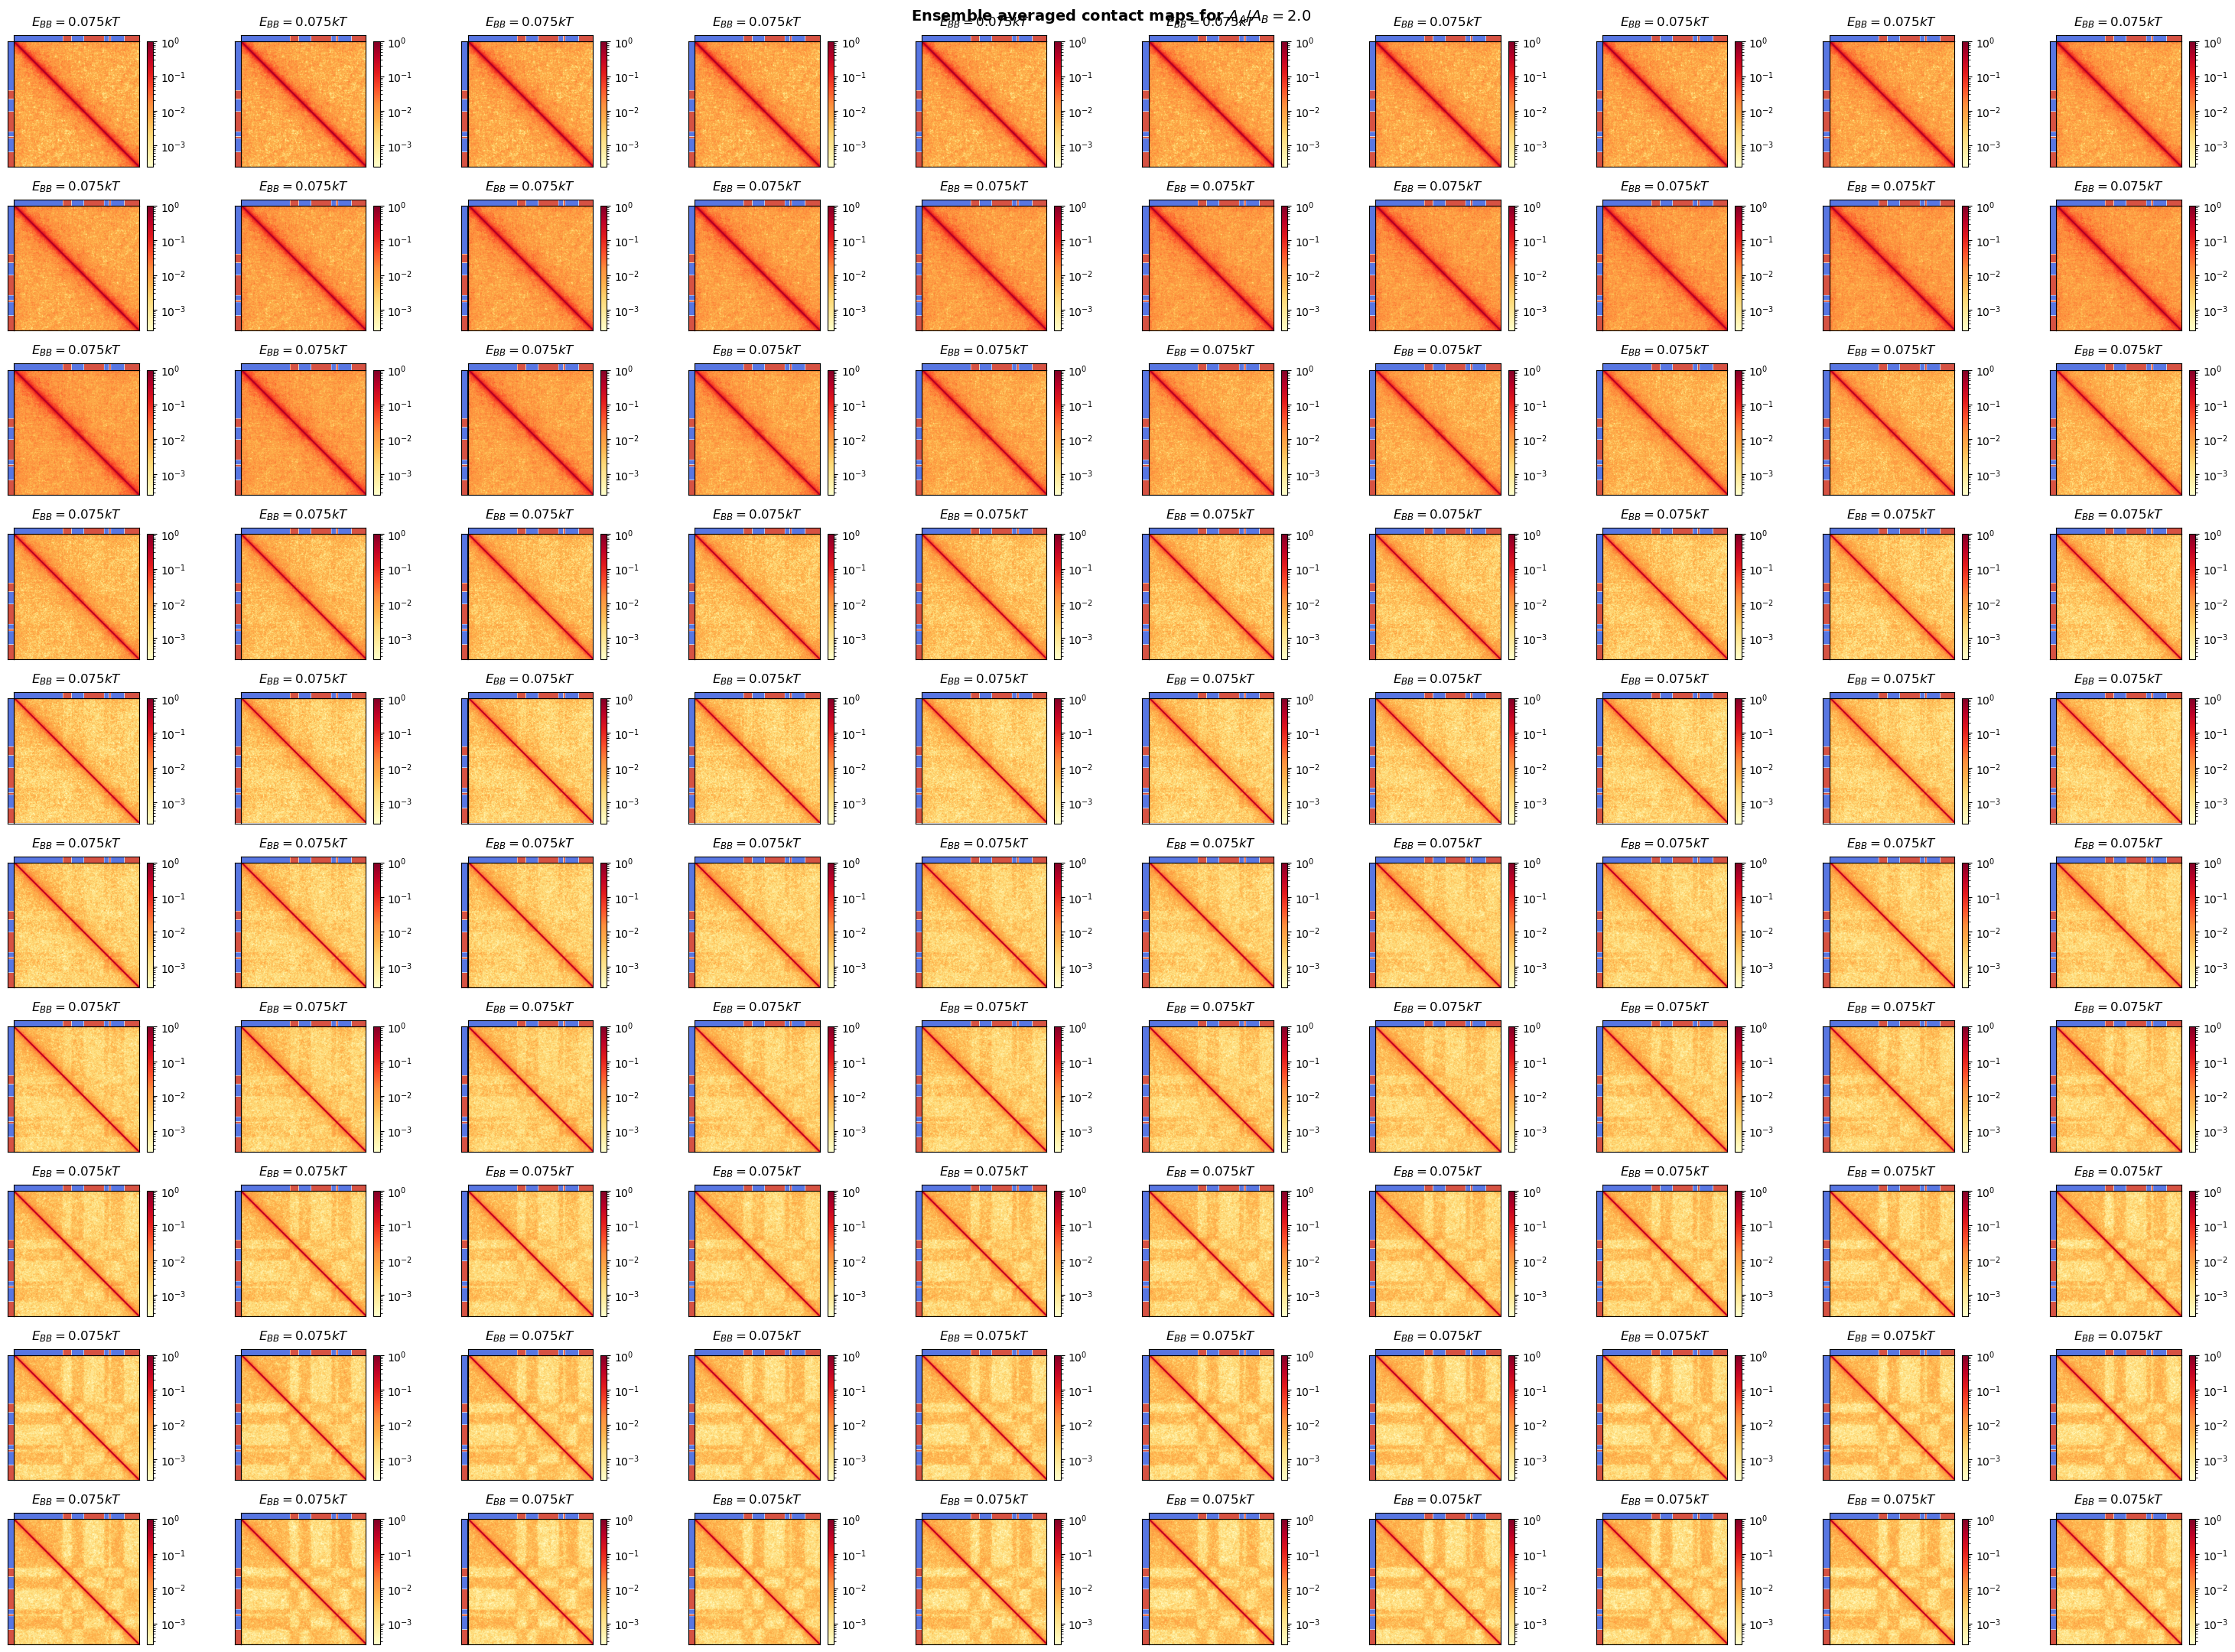

In [9]:
# plot contact maps
ABids = np.loadtxt("data/ABidentities_chr21_Su2020_2perlocus.csv", dtype=str) # make sure to change this!
ids = (ABids == "A").astype(int)

start_i_list = list(range(0, 1090, 11))
end_i_list = list(range(10, 1100, 11))
blocks = [f"{start_i_list[i]}-{end_i_list[i]}" for i in range(len(start_i_list))]
blocks = blocks[0:100]
simpath = ['stickyBB_0.075_act2']

plot_contact_maps(simpath, datapath=Path('/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/normal_logclustered'))

In [66]:
# overwrite compscore method for naming conventions
def plot_comp_score_1(acts, E0s):
    """ Compute and plot comp score as a function of distance from diagonal."""
    datapath = Path('/home/gridsan/lchan/git-remotes/polychrom_analysis/data/')
    fig, ax = plt.subplots()
    sdistances = np.arange(1, 1302)
    for act, E0 in zip(acts, E0s):
        filename = datapath/f'contact_maps/{chromo}/contact_map_stickyBB_{E0}_act{act}_cutoff2.0.npy' # change as needed
        cs, csA, csB = comp_score_1(str(filename), ids)
        ax.plot(sdistances, cs, label=f'$E_BB=${E0}, $A_A / A_B$={act}')
    if np.all(acts == acts[0]):
        ax.set_title(f"Comp score 1 for $A_A/A_B$={acts[0]}")
    elif np.all(E0s == E0s[0]):
        ax.set_title(f"Comp score 1 for $E_BB$={E0s[0]}")
    ax.set_xlabel("s")
    ax.set_ylabel("COMP score")
    plt.legend()
    fig.tight_layout()
    plt.show()

def create_starting_df(df_pathname):
    df = pd.DataFrame(columns=['act_ratio', 'E0', 'cs1', 'cs1_A', 'cs1_B'])
    df.to_csv(df_pathname)

#compute comp score on all simulation data that exists so far
def compute_comp_score_all_data(datapath=Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), cs_start=200, cs_end=1000):
    df_path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/comp_scores/cs1_{chromo}.csv'
    if (Path.exists(Path(df_path))):
        df = pd.read_csv(df_path)
    else:
        create_starting_df(df_path)
        df = pd.read_csv(df_path)
    df_a = df.set_index(['E0', 'act_ratio'])
    dict_list = []
    i = 0
    for filename in datapath.glob("*cutoff2.0*"):
        name_words = str(filename.name).split('_')
        E0 = float(name_words[3])
        act = float(name_words[4][3:])
        if df_a.index.isin([(E0, act)]).any():
            continue
        i += 1
        cs, csA, csB = comp_score_1(str(filename), ids)
        dict_list.append({"act_ratio" : act, "E0" : E0, "cs1" : np.nanmean(cs[cs_start: cs_end]),
                   "cs1_A" : np.nanmean(csA[cs_start:cs_end]), "cs1_B" : np.nanmean(csB[cs_start:cs_end])})
    print(f"Computed comp scores from {i} new simulations")
    df_b = pd.DataFrame.from_dict(dict_list)
    newdf = pd.concat([df, df_b], axis=0)
    newdf.to_csv(df_path)
    return newdf

# plot contour map
def plot_contour_map(df, blocks=None):
    if (blocks):
        df = df[df['blocks'] == blocks]
    acts = np.unique(df['act_ratio'])
    acts = acts[acts%1==0] # subset if necessary
    E0s = np.unique(df['E0'])
    E0s = E0s[E0s%0.075==0] # subset if necessary
    print(acts, E0s)
    act_grid, E0_grid = np.meshgrid(acts, E0s, indexing='xy')
    cs_Ascores = np.zeros((len(E0s), len(acts)))
    cs_Bscores = np.zeros((len(E0s), len(acts)))
    for i in range(len(acts)):
        for j in range(len(E0s)): 
            row = df.loc[(df["act_ratio"] == act_grid[j, i]) & (df["E0"] == E0_grid[j, i])]
            cs_Ascores[j, i] = float(row['cs1_A'].values[0])
            cs_Bscores[j, i] = float(row['cs1_B'].values[0])
    slide_width = 11.5
    fig, (axA, axB) = plt.subplots(1, 2, figsize=(slide_width, 0.5*slide_width))
    levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # gradient colorbar
    imA = axA.contourf(act_grid, E0_grid, cs_Ascores, cmap='plasma', levels=levels, vmax=1.0)
    imB = axB.contourf(act_grid, E0_grid, cs_Bscores, cmap='plasma', levels=levels, vmax=1.0)
    axA.set_title('A compartment score')
    axB.set_title('B compartment score')
    axA.set_xlabel(r'$A_A/ A_B$')
    axB.set_xlabel(r'$A_A/ A_B$')
    axA.set_ylabel(r'$E_{BB}$')
    fig.colorbar(imA, ax=axA)
    fig.colorbar(imB, ax=axB)

def select_contour_param(df, select_act, select_e0, blocks=None):
    if (blocks):
        df = df[df['blocks'] == blocks]
    acts = np.unique(df['act_ratio'])
    acts = acts[acts%1==0] # subset if necessary
    E0s = np.unique(df['E0'])
    E0s = E0s[E0s%0.075==0] # subset if necessary
    print(acts, E0s)
    act_grid, E0_grid = np.meshgrid(acts, E0s, indexing='xy')
    cs_Ascores = np.zeros((len(E0s), len(acts)))
    cs_Bscores = np.zeros((len(E0s), len(acts)))
    for i in range(len(acts)):
        for j in range(len(E0s)): 
            row = df.loc[(df["act_ratio"] == act_grid[j, i]) & (df["E0"] == E0_grid[j, i])]
            cs_Ascores[j, i] = float(row['cs1_A'].values[0])
            cs_Bscores[j, i] = float(row['cs1_B'].values[0])
            
    slide_width = 11.5
    plot_points = True
    fig, (axA) = plt.subplots(1, 1, figsize=(0.8 * slide_width, 0.5 * slide_width))
    levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    imA = axA.contourf(act_grid[0:11, 0:11], E0_grid[0:11, 0:11],
                       cs_Bscores[0:11, 0:11], cmap='plasma',
                       levels=levels,
                       vmax=1.0)
    
    #mark models that all have a comp score of ~ 0.3
    if plot_points:
        axA.plot(select_act, select_e0, '*', markeredgecolor='black',
                 markerfacecolor='white', markersize=12)
    fig.colorbar(imA, ax=axA)
    axA.set_title('B compartment score')
    axA.set_xlabel(r'$A_A / A_B$')
    axA.set_ylabel(r'$E_{BB}$')
    fig.tight_layout()

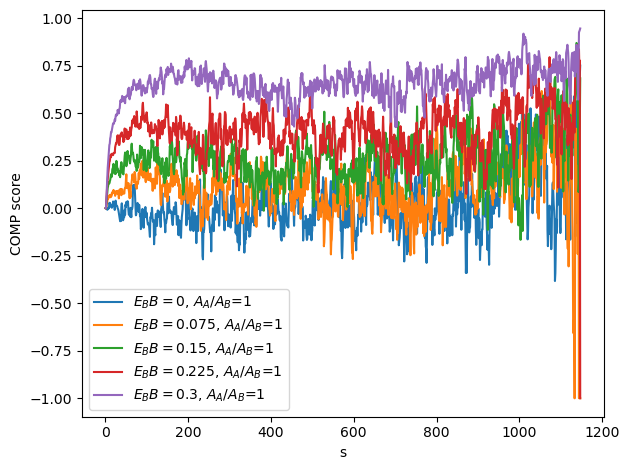

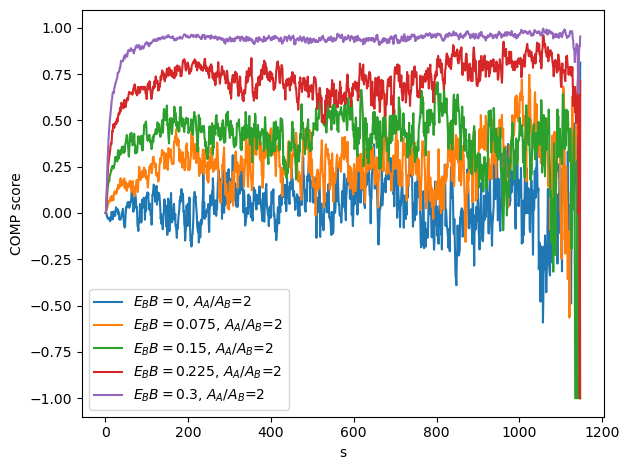

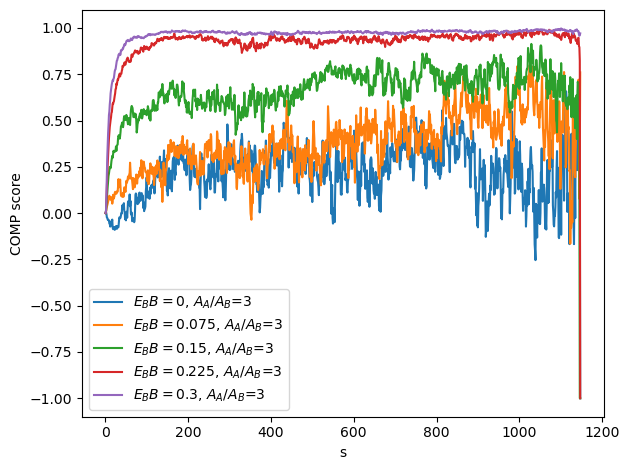

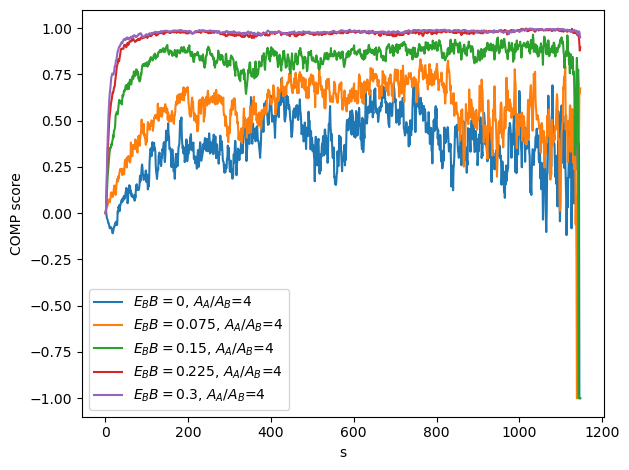

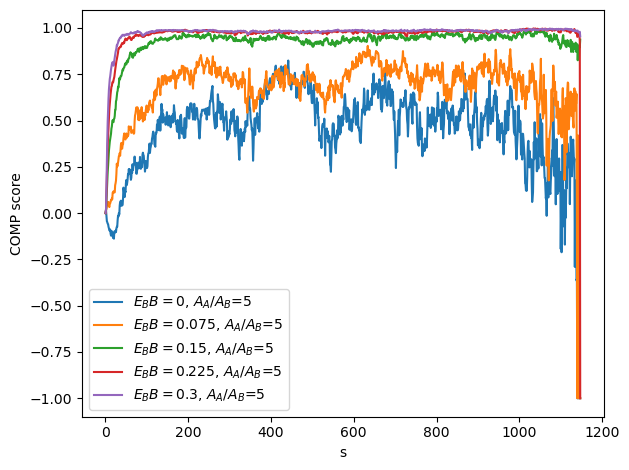

In [55]:
chromo = 'normal'
ABids = np.loadtxt("data/ABidentities_chr21_Su2020_2perlocus.csv", dtype=str) # make sure to change this!
ids = (ABids == "A").astype(int)

acts = [1, 1, 1, 1, 1]
E0s = [0, 0.075, 0.15, 0.225, 0.3]
plot_comp_score_1(acts, E0s)

acts = [2, 2, 2, 2, 2]
plot_comp_score_1(acts, E0s)

acts = [3, 3, 3, 3, 3]
plot_comp_score_1(acts, E0s)

acts = [4, 4, 4, 4, 4]
plot_comp_score_1(acts, E0s)

acts = [5, 5, 5, 5, 5]
plot_comp_score_1(acts, E0s)

Computed comp scores from 25 new simulations
[1. 2. 3. 4. 5.] [0.    0.075 0.15  0.225 0.3  ]


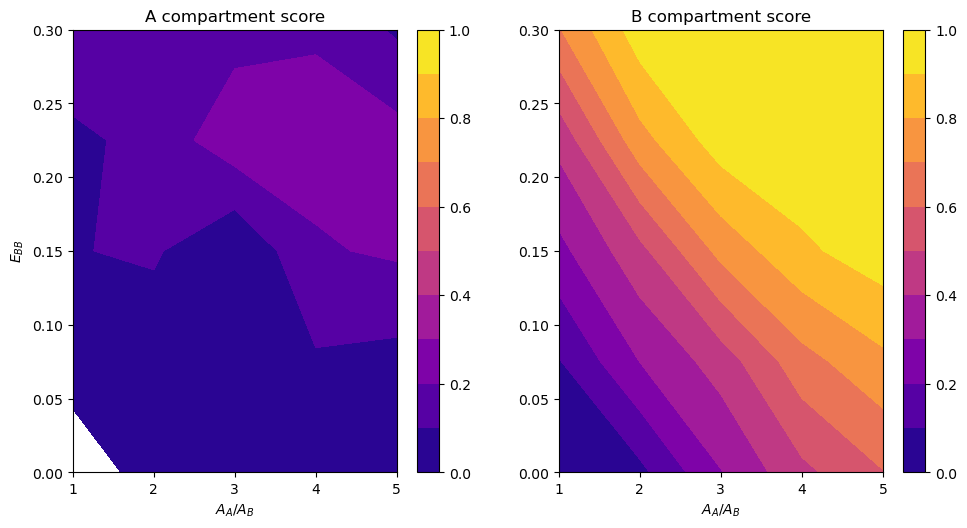

In [45]:
# create dataframe for contour plot
chromo = 'normal'
ABids = np.loadtxt("data/ABidentities_chr21_Su2020_2perlocus.csv", dtype=str) # make sure to change this!
ids = (ABids == "A").astype(int)
new_df = compute_comp_score_all_data(datapath=Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'))

# plot contour maps
plot_contour_map(new_df)

In [7]:
# create new df if new simulation path
def create_starting_dynamic_df(df_pathname):
    df = pd.DataFrame(columns=['act_ratio', 'E0', 'blocks', 'cs1', 'cs1_A', 'cs1_B']) # added blocks
    df.to_csv(df_pathname)

# design new method to plot compscores over time (i.e. over blocks)
# store in a table with columns of act_ratio, e0, blockset
def plot_dynamic_comp_score_1(acts, E0s, chromo, compartment=None, normalize=False, cs_start=200, cs_end=1000):
    """ Compute and plot comp score as a function of time (blocks).
        (string) compartment: defaults to None. select 'a' or 'b' or 'ab' to choose compartments' score.
        (boolean) normalize: defaults to False. normalizes to end-state value for dynamics. 
        (int) cs_start, cs_end: what portions of polymer/contact map to calculate the comp score from.
        """
    fig, ax = plt.subplots()
    timepoints = np.rint(np.logspace(np.log10(100), np.log10(10000*2000), 100))
    timepoints = list(timepoints.astype(int))
    df_path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/comp_scores/cs1_{chromo}_{cs_start}-{cs_end}.csv'
    if (Path.exists(Path(df_path))):
        df = pd.read_csv(df_path)
    else:
        df_path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/comp_scores/cs1_{chromo}.csv'
        df = pd.read_csv(df_path)
    for act, E0 in zip(acts, E0s):
        param_pair = df[df['act_ratio']==act][df['E0']==E0]
        param_pair = param_pair.sort_values('blocks')
        cs = list(param_pair['cs1'])
        csA = list(param_pair['cs1_A'])
        csB = list(param_pair['cs1_B'])
        if (normalize): # normalize the compscores to the steady-state or end value
            cs_end = cs[-1]
            csA_end = csA[-1]
            csB_end = csB[-1]
            cs = [item/cs_end for item in cs]
            csA = [item/csA_end for item in csA]
            csB = [item/csB_end for item in csB]
        if compartment == 'a':
            ax.plot(timepoints, csA, label=f'$E_BB=${E0}, $A_A / A_B$={act}')
        elif compartment == 'b':
            ax.plot(timepoints, csB, label=f'$E_BB=${E0}, $A_A / A_B$={act}')
        elif compartment == 'ab':
            ax.plot(timepoints, csA, label=f'$E_BB=${E0}, $A_A / A_B$={act}, A')
            ax.plot(timepoints, csB, label=f'$E_BB=${E0}, $A_A / A_B$={act}, B')
        else:    
            ax.plot(timepoints, cs, label=f'$E_BB=${E0}, $A_A / A_B$={act}')
    if np.all(acts == acts[0]):
        ax.set_title(f"Comp score 1 for $A_A/A_B$={acts[0]}")
    elif np.all(E0s == E0s[0]):
        ax.set_title(f"Comp score 1 for $E_BB$={E0s[0]}")
    ax.set_xlabel("Timesteps")
    ax.set_ylabel("COMP score")
    if (normalize):
        ax.set_ylabel("Normalized COMP score")
        ax.set_ylim(0.0, 1.3)
    ax.set_xscale('log')
    plt.legend()
    fig.tight_layout()
    plt.show()

#compute comp score on all simulation data that exists so far
def compute_dynamic_comp_score_all_data(chromo, datapath=Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids=None, cs_start=200, cs_end=1000):
    print(datapath)
    df_path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/comp_scores/cs1_{chromo}_{cs_start}-{cs_end}.csv'
    if (Path.exists(Path(df_path))):
        df = pd.read_csv(df_path)
    else:
        create_starting_dynamic_df(df_path)
        df = pd.read_csv(df_path)
    df_a = df.set_index(['E0', 'act_ratio', 'blocks'])
    dict_list = []
    i = 0
    for filename in datapath.glob("*cutoff2.0*"):
        name_words = str(filename.name).split('_')
        E0 = float(name_words[3])
        act = float(name_words[4][3:])
        blocks = int(name_words[6].split('.npy')[0].split('-')[0][6:])
        if df_a.index.isin([(E0, act, blocks)]).any():
            continue
        i += 1
        cs, csA, csB = comp_score_1(str(filename), ids)
        dict_list.append({"act_ratio" : act, "E0" : E0, "blocks" : blocks, "cs1" : np.nanmean(cs[cs_start:cs_end]),
                   "cs1_A" : np.nanmean(csA[cs_start:cs_end]), "cs1_B" : np.nanmean(csB[cs_start:cs_end])})
    print(f"Computed comp scores from {i} new simulations")
    df_b = pd.DataFrame.from_dict(dict_list)
    newdf = pd.concat([df, df_b], axis=0)
    newdf.to_csv(df_path)
    return newdf


In [48]:
chromo = 'normal_logclustered'
ABids = np.loadtxt("data/ABidentities_chr21_Su2020_2perlocus.csv", dtype=str) # make sure to change this!
ids = (ABids == "A").astype(int)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=200, cs_end=1000)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=0, cs_end=250)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=250, cs_end=500)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=500, cs_end=750)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=750, cs_end=1000)

chromo = 'blocky1_logclustered'
ABids = np.loadtxt("data/ABidentities_chr21_Su2020_blocky1.csv", dtype=str) # make sure to change this!
ids = (ABids == "A").astype(int)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=200, cs_end=1000)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=0, cs_end=250)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=250, cs_end=500)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=500, cs_end=750)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=750, cs_end=1000)

chromo = 'blocky2_logclustered'
ABids = np.loadtxt("data/ABidentities_chr21_Su2020_blocky2.csv", dtype=str) # make sure to change this!
ids = (ABids == "A").astype(int)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=200, cs_end=1000)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=0, cs_end=250)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=250, cs_end=500)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=500, cs_end=750)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=750, cs_end=1000)

chromo = 'artificial1_logclustered'
ABids = np.loadtxt("data/ABidentities_chr21_Su2020_artificial1.csv", dtype=str) # make sure to change this!
ids = (ABids == "A").astype(int)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=200, cs_end=1000)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=0, cs_end=250)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=250, cs_end=500)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=500, cs_end=750)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=750, cs_end=1000)

chromo = 'artificial2_logclustered'
ABids = np.loadtxt("data/ABidentities_chr21_Su2020_artificial2.csv", dtype=str) # make sure to change this!
ids = (ABids == "A").astype(int)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=200, cs_end=1000)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=0, cs_end=250)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=250, cs_end=500)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=500, cs_end=750)
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=750, cs_end=1000)

/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/normal_logclustered
Computed comp scores from 300 new simulations
/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/normal_logclustered
Computed comp scores from 0 new simulations
/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/normal_logclustered
Computed comp scores from 0 new simulations
/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/normal_logclustered
Computed comp scores from 0 new simulations
/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/normal_logclustered
Computed comp scores from 0 new simulations
/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/blocky1_logclustered
Computed comp scores from 400 new simulations
/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/blocky1_logclustered
Computed comp scores from 0 new simulations
/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  act_ratio     E0  \
0                0           0.0           0.0         NaN        1.0  0.000   
1                1           1.0           1.0         NaN        1.0  0.150   
2                2           2.0           2.0         NaN        2.0  0.000   
3                3           3.0           3.0         NaN        3.0  0.225   
4                4           4.0           4.0         NaN        5.0  0.000   
...            ...           ...           ...         ...        ...    ...   
2895           395           NaN           NaN         NaN        2.0  0.160   
2896           396           NaN           NaN         NaN        2.0  0.160   
2897           397           NaN           NaN         NaN        1.0  0.250   
2898           398           NaN           NaN         NaN        2.0  0.160   
2899           399           NaN           NaN         NaN        1.0  0.250   

      blocks       cs1     cs1_A     cs1_B  
0        946 -0.003763 -0.000003 -0.007053  
1        682  0.231171  0.117173  0.255521  
2        429  0.057692 -0.006496  0.076049  
3        319  0.396494  0.133963  0.446170  
4        825  0.181915  0.050072  0.211917  
...      ...       ...       ...       ...  
2895     572  0.313238  0.101017  0.353137  
2896       0  0.024563 -0.009484  0.033967  
2897    1045  0.511271  0.338194  0.546883  
2898    1067  0.486830  0.363736  0.515734  
2899    1023  0.519476  0.344609  0.552650  

[2900 rows x 10 columns]

/state/partition1/slurm_tmp/25073326.0.0/ipykernel_489821/3266012685.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  param_pair = df[df['act_ratio']==act][df['E0']==E0]


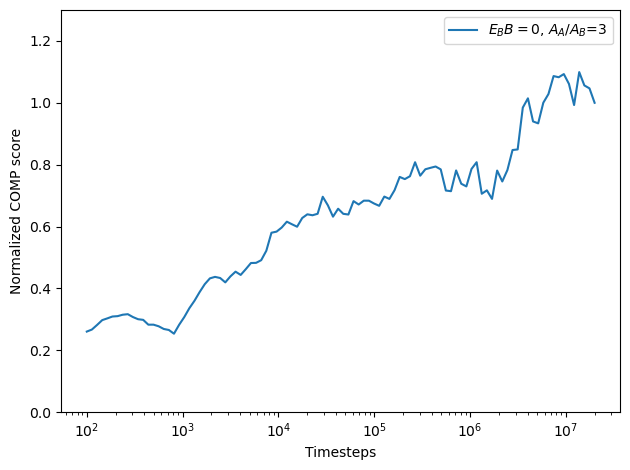

/state/partition1/slurm_tmp/25073326.0.0/ipykernel_489821/3266012685.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  param_pair = df[df['act_ratio']==act][df['E0']==E0]


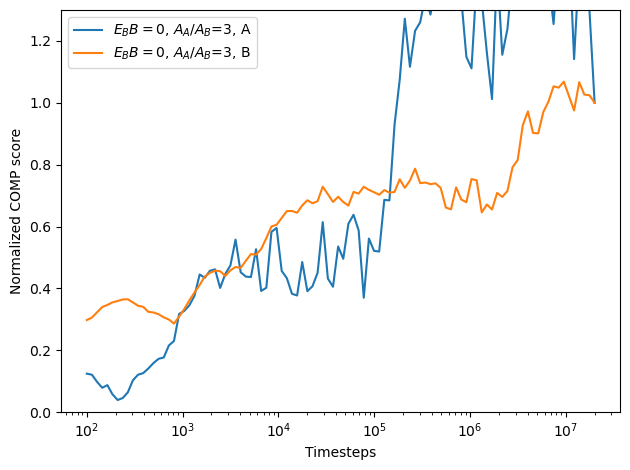

In [73]:
chromo = 'normal_logclustered'
acts1 = [1, 1, 1, 1, 1]
acts2 = [2, 2, 2, 2, 2]
acts3 = [3, 3, 3, 3, 3]
acts4 = [4, 4, 4, 4, 4]
acts5 = [5, 5, 5, 5, 5]
a=[3]
acts = [1,2,3,4,5]
E0s = [0.175, 0.12, 0.075, 0.04, 0] # normal
e=[0]
#E0s = [0.25, 0.17, 0.1, 0.04, 0] # artificial1
#E0s = [0.25, 0.16, 0.1, 0.05, 0] # artificial2
#E0s = [0.25, 0.17, 0.11, 0.05, 0] # blocky1
#E0s = [0.23, 0.15, 0.10, 0.05, 0] # blocky2
#E0s = [0, 0.075, 0.15, 0.225, 0.3] # parameter sweep
plot_dynamic_comp_score_1(a, e, chromo, normalize=True) # note that acts and E0s are mapped one to one, i.e. must be same length
#plot_dynamic_comp_score_1(acts1, E0s, chromo, 'ab', normalize=True)
#plot_dynamic_comp_score_1(acts2, E0s, chromo, 'ab', normalize=True)
plot_dynamic_comp_score_1(a, e, chromo, 'ab', normalize=True)
#plot_dynamic_comp_score_1(acts4, E0s, chromo, 'ab', normalize=True)
#plot_dynamic_comp_score_1(acts5, E0s, chromo, 'ab', normalize=True)
#plot_dynamic_comp_score_1(acts, E0s, chromo, 'a')
#plot_dynamic_comp_score_1(acts, E0s, chromo, 'b')
#plot_dynamic_comp_score_1(acts, E0s, chromo, 'ab', normalize=True)

[1. 2. 3. 4. 5.] [0.    0.075 0.15  0.225 0.3  ]
[1. 2. 3. 4. 5.] [0.    0.075 0.15  0.225 0.3  ]
[1. 2. 3. 4. 5.]


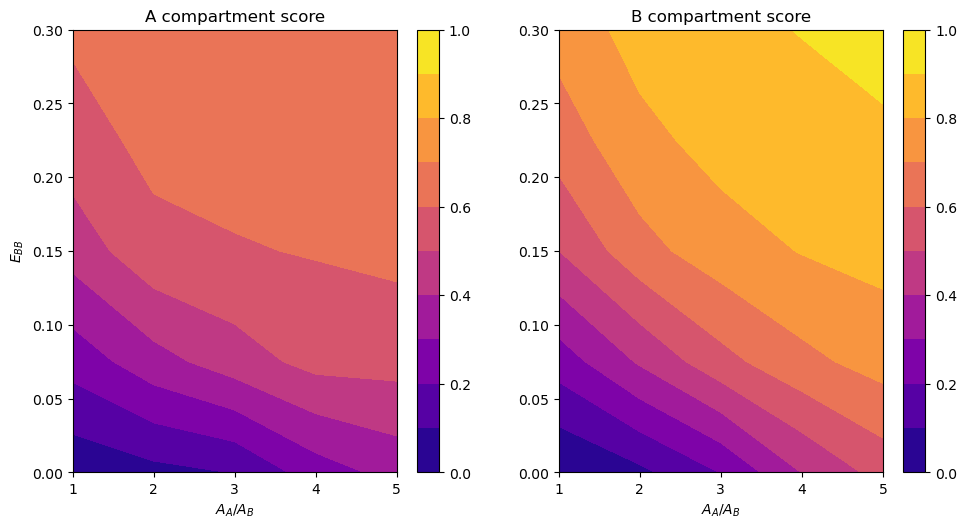

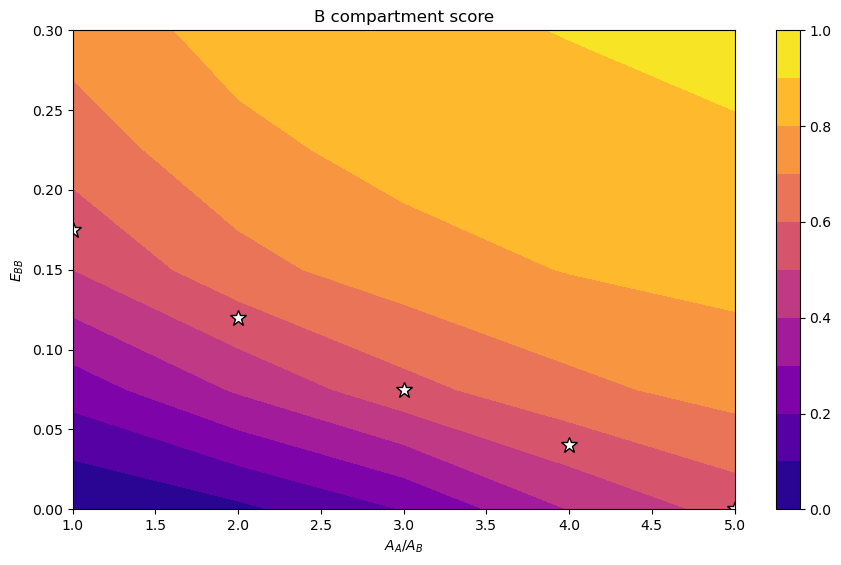

In [28]:
chromo = 'normal_logclustered'
df_path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/comp_scores/cs1_{chromo}.csv'
df = pd.read_csv(df_path)
plot_contour_map(df, 1089)

select_act = [1, 2, 3, 4, 5]
select_e0 = [0.175, 0.12, 0.075, 0.04, 0]
select_contour_param(df, select_act, select_e0, 1089)

[1. 2. 3. 4. 5.] [0.    0.075 0.15  0.225 0.3  ]
[1. 2. 3. 4. 5.] [0.    0.075 0.15  0.225 0.3  ]
[1. 2. 3. 4. 5.]


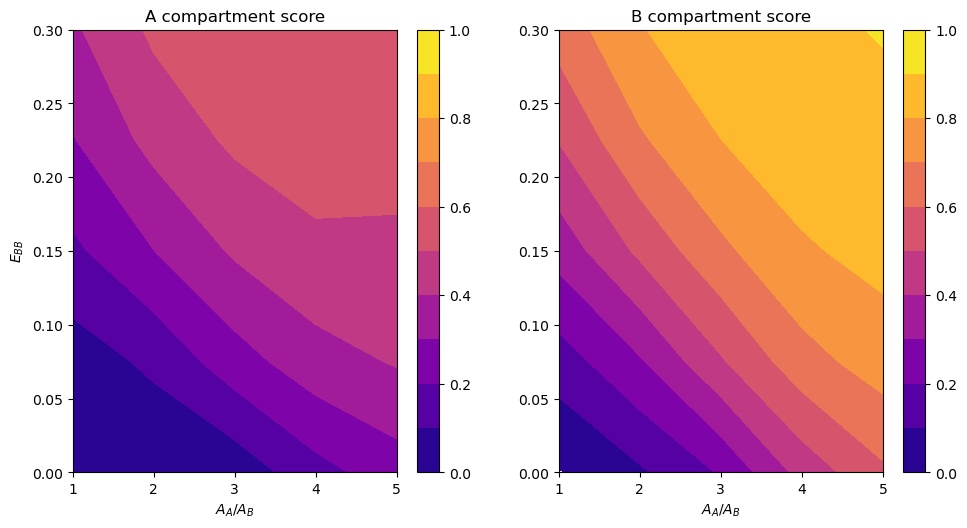

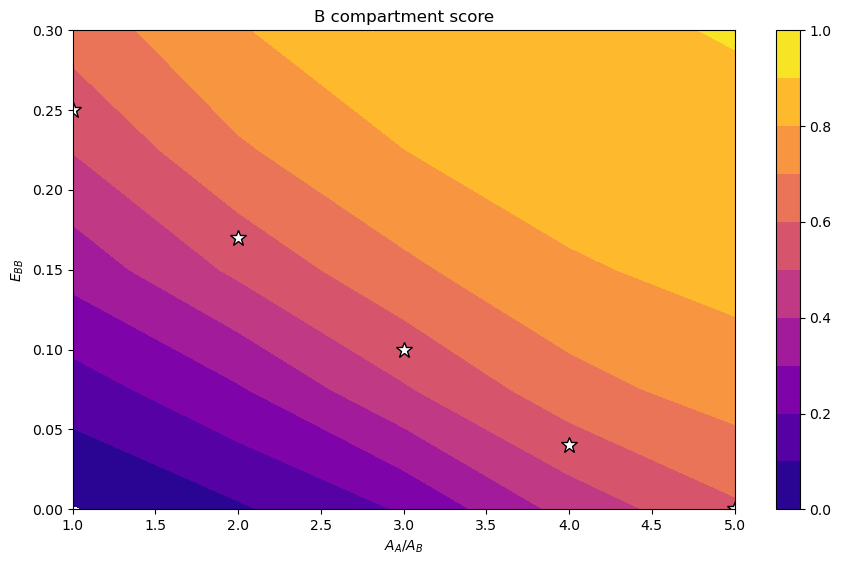

In [31]:
chromo = 'artificial1_logclustered'
df_path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/comp_scores/cs1_{chromo}.csv'
df = pd.read_csv(df_path)
plot_contour_map(df, 1089)

select_act = [1, 2, 3, 4, 5]
select_e0 = [0.25, 0.17, 0.1, 0.04, 0]
select_contour_param(df, select_act, select_e0, 1089)

[1. 2. 3. 4. 5.] [0.    0.075 0.15  0.225 0.3  ]
[1. 2. 3. 4. 5.] [0.    0.075 0.15  0.225 0.3  ]
[1. 2. 3. 4. 5.]


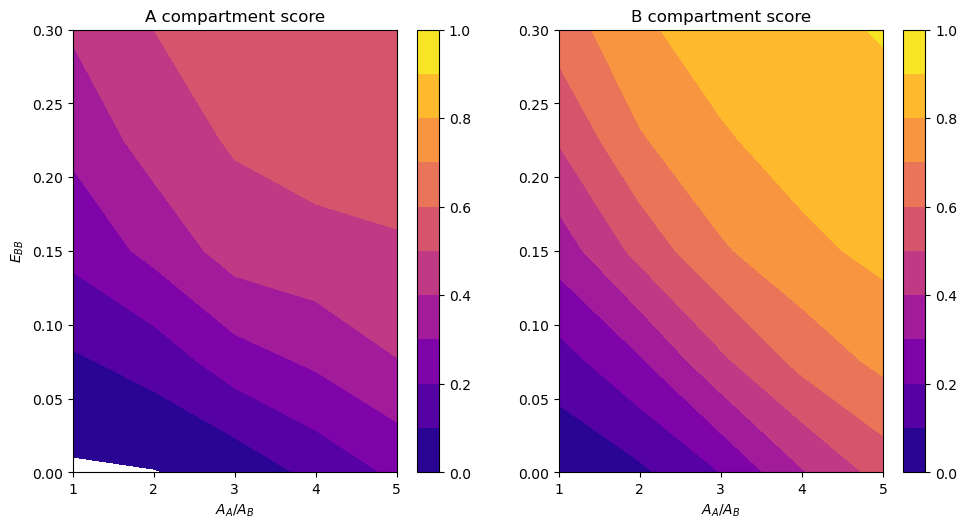

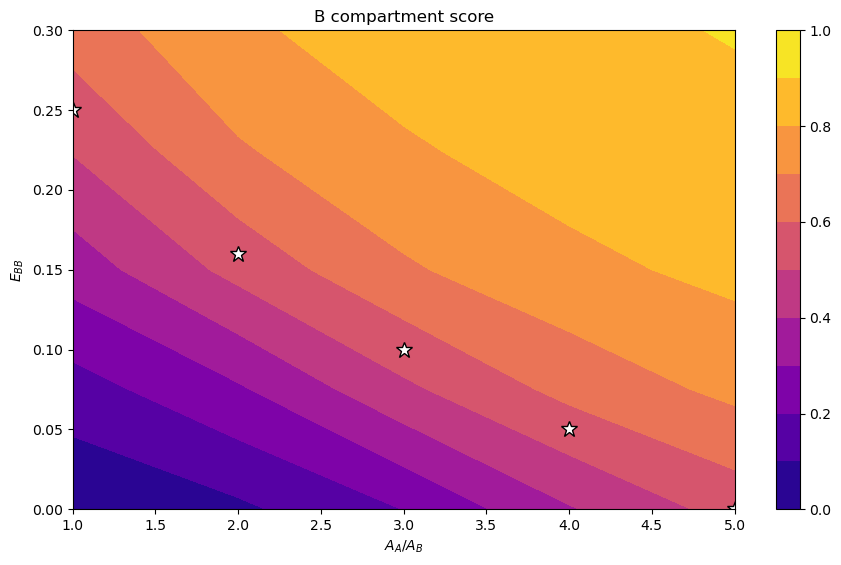

In [33]:
chromo = 'artificial2_logclustered'
df_path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/comp_scores/cs1_{chromo}.csv'
df = pd.read_csv(df_path)
plot_contour_map(df, 1089)

select_act = [1, 2, 3, 4, 5]
select_e0 = [0.25, 0.16, 0.1, 0.05, 0]
select_contour_param(df, select_act, select_e0, 1089)

[1. 2. 3. 4. 5.] [0.    0.075 0.15  0.3  ]
[1. 2. 3. 4. 5.] [0.    0.075 0.15  0.3  ]


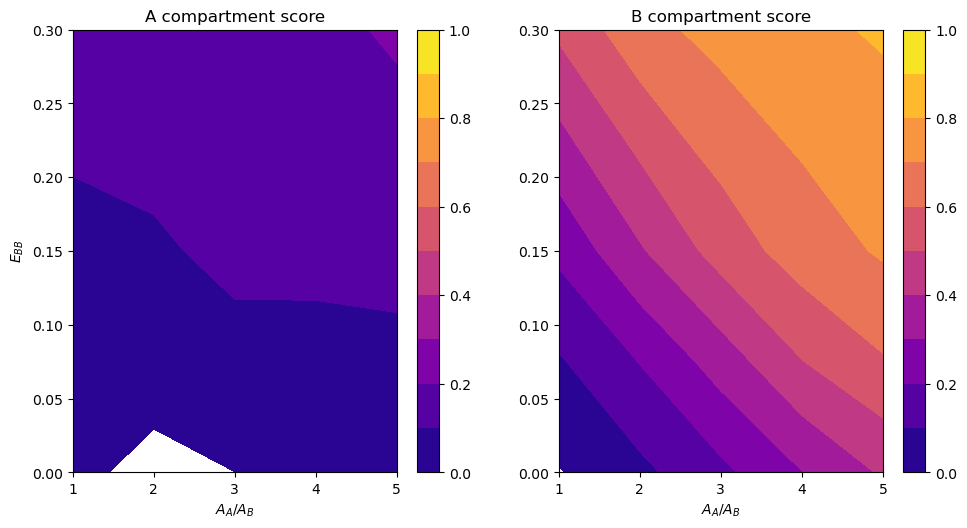

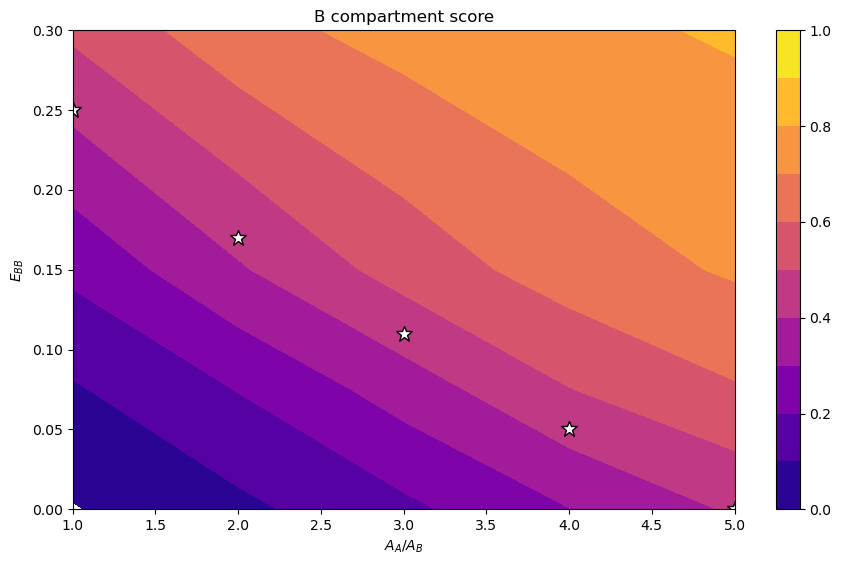

In [67]:
chromo = 'blocky1_logclustered'
df_path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/comp_scores/cs1_{chromo}_200-1000.csv'
df = pd.read_csv(df_path)
plot_contour_map(df, 1089)

select_act = [1, 2, 3, 4, 5]
select_e0 = [0.25, 0.17, 0.11, 0.05, 0]
select_contour_param(df, select_act, select_e0, 1089)

[1. 2. 3. 4. 5.] [0.    0.075 0.15  0.225 0.3  ]
[1. 2. 3. 4. 5.] [0.    0.075 0.15  0.225 0.3  ]
[1. 2. 3. 4. 5.]


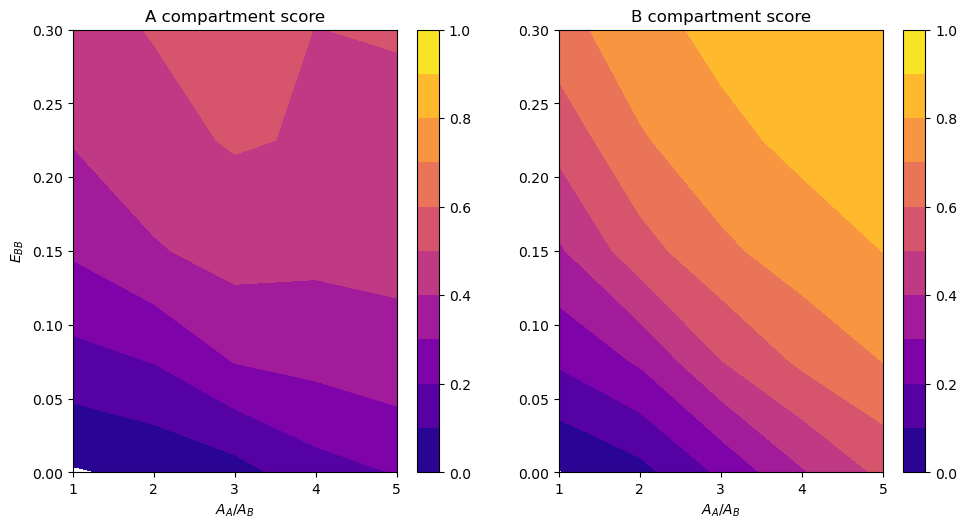

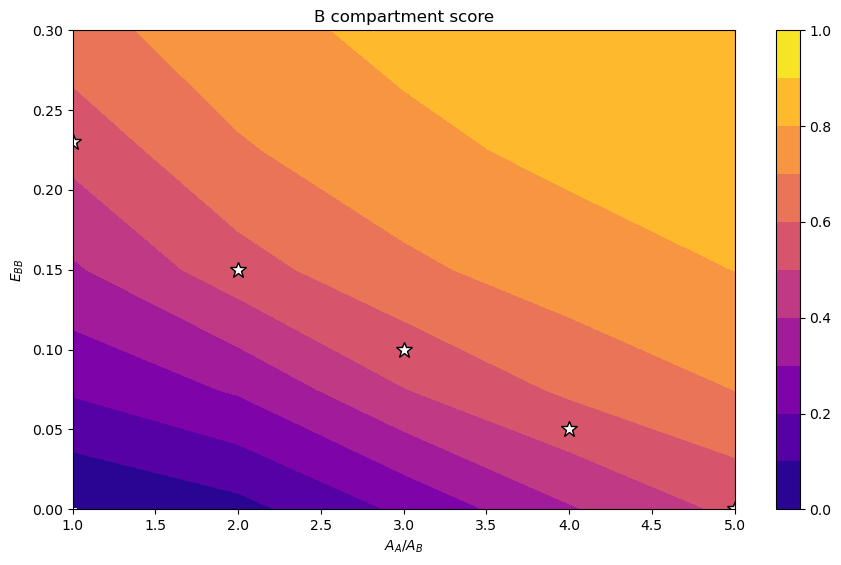

In [39]:
chromo = 'blocky2_logclustered'
df_path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/comp_scores/cs1_{chromo}.csv'
df = pd.read_csv(df_path)
plot_contour_map(df, 1089)

select_act = [1, 2, 3, 4, 5]
select_e0 = [0.23, 0.15, 0.10, 0.05, 0]
select_contour_param(df, select_act, select_e0, 1089)

In [34]:
import seaborn as sns
from matplotlib.colors import ListedColormap
def plot_diagonal_diffs(act, E0, chromo, compartment=None, normalize=False):
    """ Compute and plot comp score as a function of time (blocks).
        (float) act, E0: a pair of values. only visualizes one pair at a time.
        (string) compartment: defaults to None. select 'a' or 'b' or 'ab' to choose compartments' score.
        (boolean) normalize: defaults to False. normalizes to end-state value for dynamics. 
        """
    fig, ax = plt.subplots()
    timepoints = np.rint(np.logspace(np.log10(100), np.log10(10000*2000), 100))
    timepoints = list(timepoints.astype(int))
    cs_intervals = [(200, 1000), (0, 250), (250, 500), (500, 750), (750, 1000)]
    
    colors = sns.color_palette("viridis")
    i = 0 # for coloring purposes
    for (cs_int_start, cs_int_end) in cs_intervals:
        df_path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/comp_scores/cs1_{chromo}_{cs_int_start}-{cs_int_end}.csv'
        if (Path.exists(Path(df_path))):
            df = pd.read_csv(df_path)
        else:
            df_path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/comp_scores/cs1_{chromo}.csv'
            df = pd.read_csv(df_path)
        param_pair = df[df['act_ratio']==act][df['E0']==E0]
        param_pair = param_pair.sort_values('blocks')
        cs = list(param_pair['cs1'])
        csA = list(param_pair['cs1_A'])
        csB = list(param_pair['cs1_B'])
        if (normalize): # normalize the compscores to the steady-state or end value
            cs_end = cs[-1]
            csA_end = csA[-1]
            csB_end = csB[-1]
            cs = [item/cs_end for item in cs]
            csA = [item/csA_end for item in csA]
            csB = [item/csB_end for item in csB]
        if compartment == 'a':
            ax.plot(timepoints, csA, label=f'$E_BB=${E0}, $A_A / A_B$={act}, {cs_int_start}-{cs_int_end}', color = colors[i])
        elif compartment == 'b':
            ax.plot(timepoints, csB, label=f'$E_BB=${E0}, $A_A / A_B$={act}, {cs_int_start}-{cs_int_end}', color = colors[i])
        elif compartment == 'ab':
            ax.plot(timepoints, csA, label=f'$E_BB=${E0}, $A_A / A_B$={act}, A, {cs_int_start}-{cs_int_end}')
            ax.plot(timepoints, csB, label=f'$E_BB=${E0}, $A_A / A_B$={act}, B, {cs_int_start}-{cs_int_end}')
        else:    
            ax.plot(timepoints, cs, label=f'$E_BB=${E0}, $A_A / A_B$={act}, {cs_int_start}-{cs_int_end}', color = colors[i])
        
        i+=1 # for coloring purposes
    ax.set_xlabel("Timesteps")
    ax.set_ylabel("COMP score")
    if (normalize):
        ax.set_ylabel("Normalized COMP score")
        ax.set_ylim(0.0, 1.3)
    ax.set_xscale('log')
    plt.legend()
    fig.tight_layout()
    plt.show()

/state/partition1/slurm_tmp/25073326.0.0/ipykernel_489821/884021756.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  param_pair = df[df['act_ratio']==act][df['E0']==E0]
/state/partition1/slurm_tmp/25073326.0.0/ipykernel_489821/884021756.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  param_pair = df[df['act_ratio']==act][df['E0']==E0]
/state/partition1/slurm_tmp/25073326.0.0/ipykernel_489821/884021756.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  param_pair = df[df['act_ratio']==act][df['E0']==E0]
/state/partition1/slurm_tmp/25073326.0.0/ipykernel_489821/884021756.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  param_pair = df[df['act_ratio']==act][df['E0']==E0]
/state/partition1/slurm_tmp/25073326.0.0/ipykernel_489821/884021756.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  param_pair = df[df['act_rat

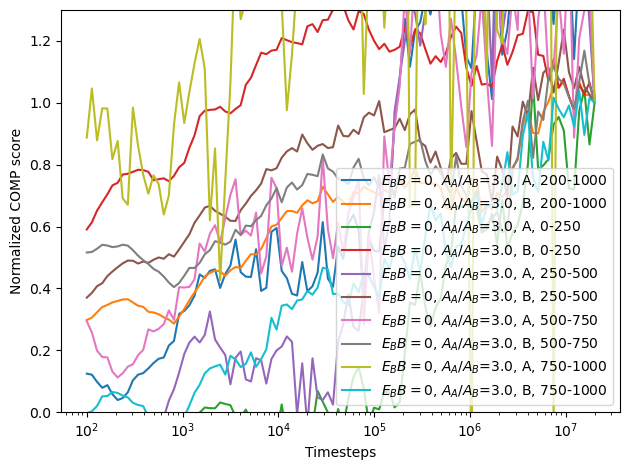

/state/partition1/slurm_tmp/25073326.0.0/ipykernel_489821/884021756.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  param_pair = df[df['act_ratio']==act][df['E0']==E0]
/state/partition1/slurm_tmp/25073326.0.0/ipykernel_489821/884021756.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  param_pair = df[df['act_ratio']==act][df['E0']==E0]
/state/partition1/slurm_tmp/25073326.0.0/ipykernel_489821/884021756.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  param_pair = df[df['act_ratio']==act][df['E0']==E0]
/state/partition1/slurm_tmp/25073326.0.0/ipykernel_489821/884021756.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  param_pair = df[df['act_ratio']==act][df['E0']==E0]
/state/partition1/slurm_tmp/25073326.0.0/ipykernel_489821/884021756.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  param_pair = df[df['act_rat

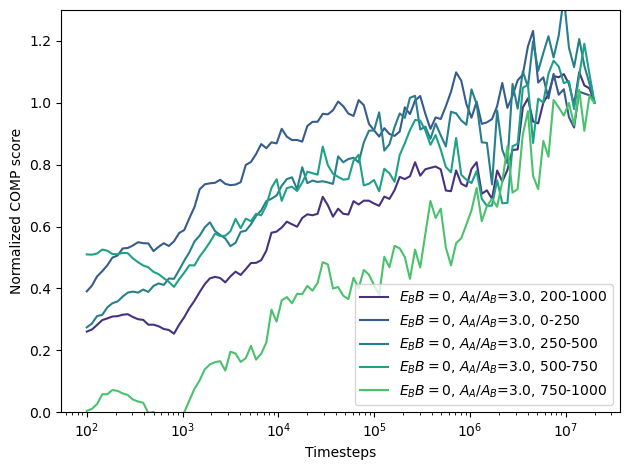

In [70]:
#plot_diagonal_diffs(2.0, 0.225, 'normal_logclustered', compartment='a', normalize=True)
chromo = 'normal_logclustered'
plot_diagonal_diffs(3.0, 0, chromo, compartment = 'ab', normalize=True)
#plot_diagonal_diffs(1.0, 0.3, chromo, compartment = 'ab', normalize=True)
#plot_diagonal_diffs(3.0, 0.15, chromo, compartment = 'ab', normalize=True)
#plot_diagonal_diffs(5.0, 0, chromo, compartment = 'ab', normalize=True)

plot_diagonal_diffs(3.0, 0, chromo, normalize=True)
#plot_diagonal_diffs(1.0, 0.3, chromo, normalize=True)
#plot_diagonal_diffs(3.0, 0.15, chromo, normalize=True)
#plot_diagonal_diffs(5.0, 0, chromo, normalize=True)

In [77]:
timepoints = np.rint(np.logspace(np.log10(100), np.log10(10000*2000), 100))
timepoints = list(timepoints.astype(int))
print(timepoints[0:20])

[100, 113, 128, 145, 164, 185, 210, 237, 268, 303, 343, 388, 439, 497, 562, 636, 719, 813, 920, 1041]
